In [2]:
import geopandas as gpd
import pandas as pd
import folium as fl
import numpy as np
from shapely.geometry import Point
import os
import linkingtool.linking_utility as utils
import atlite

* To Print the Plot Generation Date

In [3]:
import datetime

# Get today's date and time
now = datetime.datetime.now()
date_time_str = now.strftime("%Y-%m-%d %H:%M:%S")

* Load Config

In [4]:
config_file_path ='config/config_linking_tool.yml'
config=utils.load_config(config_file_path)

current_region=config['regional_info']['region_1']
_CRC_=current_region['code'] #Current Region Code

# Explanation of the Config files

 * Load GADM regional data file.

In [5]:
gadm_regions_gdf = gpd.read_file('data/downloaded_data/GADM/BC_gadm_regions.geojson')

* Load Aeroway Data

In [6]:
# aeroway=gpd.read_file(f'data/OSM/aeroway/{_CRC_}/aeroway_OSM_{_CRC_}.geojson')

 * Load Conversation lands

In [7]:
conservation_protected_lands=gpd.read_parquet('data/linking_tool/CPCAD_BC_union.parquet')
# BC_protectedLands.explore('IUCN_CAT_desc',legend=True)

>old database

In [8]:
# conservation_lands = gpd.read_file('data/BC_gov/Conservation Lands/WCL_CONSERVATION_LANDS_SP.gdb') # old database
# Source: https://www.env.gov.bc.ca/soe/indicators/land/protected-lands-and-waters.html
# conservation_lands.explore('TENURE_TYPE',legend=True)

 * Load Transmission Lines & Substations

In [9]:
buses_gdf = gpd.GeoDataFrame(pd.read_pickle('data/processed_data/BC_Transmission.pkl'))
print(f">> {len(buses_gdf)} Transmission Nodes Loaded")

# transmission_lines=gpd.read_file('data/BC_gov/TransmissionLine/BCGW_7113060B_1710035634909_9496/GBA_TRANSMISSION_LINES_SP.gdb')
# tx_line_length=transmission_lines['FEATURE_LENGTH_M'].sum()/1E6
# print(f">> {tx_line_length:.2f} Th.km Transmission Lines Loaded")

>> 939 Transmission Nodes Loaded


 * Load Existing Sites

In [10]:
existing_resources='data/downloaded_data/Gov/BC_gov/PowerPlantsRenewGE1MW_NorthAmerica_201708_SHP'
existing_resources=gpd.read_file(existing_resources)

BC_mask = (existing_resources['Country'] == 'Canada') & (existing_resources['StateProv'] == 'British Columbia')

BC_existing_VRE=existing_resources[BC_mask]

wind_mask=BC_existing_VRE['Wind_MW']>0
solar_mask=BC_existing_VRE['Solar_MW']>0

Wind_existing=BC_existing_VRE[wind_mask]
Solar_existing=BC_existing_VRE[solar_mask]

Wind_existing=Wind_existing.loc[:,['Country', 'Facility', 'Owner', 'Operator', 'Latitude', 'Longitude',
       'City', 'County', 'StateProv', 'ZipCode', 'Address',
       'Wind_MW', 'Source', 'Period','geometry']]

Solar_existing=Solar_existing.loc[:,['Country', 'Facility', 'Owner', 'Operator', 'Latitude', 'Longitude',
       'City', 'County', 'StateProv', 'ZipCode', 'Address',
       'Solar_MW', 'Source', 'Period','geometry']]

generators_existing=pd.read_csv('/local-scratch/localhome/mei3/eliasinul/repositories/PyPSA_BC/data/SESIT/CODERS/data-pull/supply/generators.csv')
BC_mask=generators_existing.operating_region=='British Columbia'
gen_existing_BC=generators_existing[BC_mask]

# CODERS data
wind_gen_existing_BC_wind=gen_existing_BC[gen_existing_BC.gen_type_copper=='wind']

df=wind_gen_existing_BC_wind
# Assuming your DataFrame is named 'df' and has columns 'latitude' and 'longitude'
geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
crs = {'init': 'epsg:4326'}  # Assuming WGS 84 coordinate reference system
wind_gen_existing_BC_wind_gdf = gpd.GeoDataFrame(df, geometry=geometry, crs=crs)


/localhome/mei3/miniconda3/envs/linkingtool/lib/python3.12/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


## From Linking Tool

 * Load Solar Sites 

In [11]:
solar_buckets_file=f"results/linking/Solar_Top_Sites_Clustered.pkl"
solar_buckets_CFts_file=f"results/linking/Solar_Top_Sites_Clustered_CF_timeseries.pkl"

# Convert DataFrames to GeoDataFrames for buses
solar_buckets_gdf = pd.read_pickle(solar_buckets_file)
solar_buckets_CFts = pd.read_pickle(solar_buckets_CFts_file)

solar_buckets_gdf_all = pd.read_pickle('data/linking_tool/solar/ERA5_cell_cluster_filtered_all_sites.pkl')

In [12]:
# import folium
# m=gadm_regions_gdf.explore(style_kwds={'fillOpacity': 0.1}, name=f'Admin Regions - {current_region['code']} ')
# solar_buckets_gdf.explore("Region",m=m,style_kwds={'fillOpacity': 0.7}, name=f'Potential Solar Sites - {current_region['code']} ')
# Solar_existing.explore(m=m,style_kwds={'fillOpacity': 0.7}, name=f'Existing Solar Sites - {current_region['code']}')

# # Add layer control
# folium.LayerControl().add_to(m)

# # Display the map
# m.save(f'vis/Solar/{current_region['code']}_Solar_Resource_Options_map.html')
# m

 * Load Wind Data

In [13]:
wind_buckets_gdf_all = pd.read_pickle('data/linking_tool/wind/GWA_cell_cluster_filtered_all_sites.pkl')
wind_buckets_file=f"results/linking/Wind_Top_Sites_Clustered.pkl"
wind_buckets_CFts_file=f"results/linking/Wind_Top_Sites_Clustered_CF_timeseries.pkl"

# Convert DataFrames to GeoDataFrames for buses
wind_buckets_gdf = pd.read_pickle(wind_buckets_file)
wind_buckets_CFts = pd.read_pickle(wind_buckets_CFts_file)

* How many Turbines We need to Place ?

In [14]:
wind_turbine_nominal_capacity:int=config['capacity_disaggregation']['wind']['turbines']['atlite']['model_2_P'] #MW
wind_buckets_gdf['No_of_turbines'] = np.floor(wind_buckets_gdf['potential_capacity'] / wind_turbine_nominal_capacity).astype(int)
mask=wind_buckets_gdf.potential_capacity>=wind_turbine_nominal_capacity
len(wind_buckets_gdf[mask])
# wind_buckets_gdf[mas].head(10).explore('potential_capacity')

6

In [15]:
# # Export DataFrame to Excel
# wind_buckets_gdf.to_excel('results/wind_buckets.xlsx', index=False)  # 'index=False' prevents writing row numbers
# solar_buckets_gdf.to_excel('results/solar_buckets.xlsx', index=False)  # 'index=False' prevents writing row numbers

# Visualization

## Static

In [16]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
import cartopy.feature as cfeature

/tmp/ipykernel_4105329/1856720283.py:10: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  solar_buckets_gdf.plot('CF_mean', ax=ax, alpha=0.6, color="Green")


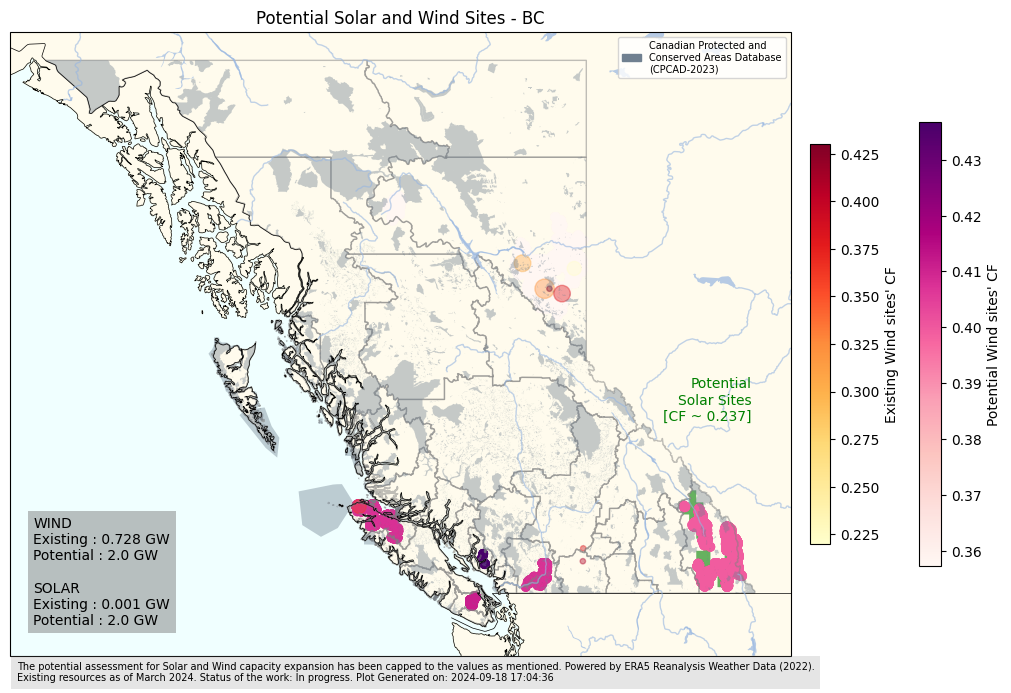

In [17]:
# Create the figure and axes
fig = plt.figure(figsize=(12, 7))
ax = plt.axes(projection=ccrs.PlateCarree())

# Set the title
plt.title("Potential Solar and Wind Sites - BC")

# Potential Solar Sites
solar_buckets_gdf=  solar_buckets_gdf #solar_buckets_gdf_all
solar_buckets_gdf.plot('CF_mean', ax=ax, alpha=0.6, color="Green")

# Add the green text "Potential Solar Sites" on the right side of the plot
plt.text(0.95, 0.41, f"Potential\nSolar Sites\n[CF ~ {round(solar_buckets_gdf.CF_mean.mean(),3)}]",
         transform=ax.transAxes, fontsize=10, color='green', ha='right', va='center')

# Potential Wind Sites
wind_buckets_gdf= wind_buckets_gdf #wind_buckets_gdf_all
wind_buckets_gdf_plot = wind_buckets_gdf.plot('CF_mean', ax=ax, cmap='RdPu')
cmap_wind = plt.cm.ScalarMappable(cmap='RdPu')
cmap_wind.set_array(wind_buckets_gdf['CF_mean'])
cbar_wind = plt.colorbar(cmap_wind, ax=ax, orientation='vertical', fraction=0.02, pad=0.08,
                         label="Potential Wind sites' CF")

# Existing Wind Sites
wind_gen_existing_BC_wind_gdf.plot('capacity_factor_in_%', ax=ax, markersize='install_capacity_in_mw', alpha=0.4,
                                   cmap='YlOrRd')
cmap_wind_ex = plt.cm.ScalarMappable(cmap='YlOrRd')
cmap_wind_ex.set_array(wind_gen_existing_BC_wind_gdf['capacity_factor_in_%'])
cbar_wind_ex = plt.colorbar(cmap_wind_ex, ax=ax, orientation='vertical', fraction=0.02, pad=0.02,
                            label="Existing Wind sites' CF")

# GADM Boundaries
gadm_regions_gdf.plot(ax=ax, alpha=0.5, edgecolor='grey', color="None")

# Baseline map features
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.OCEAN, color="azure")
ax.add_feature(cfeature.RIVERS, alpha=0.6)
ax.add_feature(cfeature.LAKES, alpha=0.7)
ax.add_feature(cfeature.LAND, color="cornsilk", alpha=0.5)

# Conservation & Protected lands
conservation_protected_lands.plot(ax=ax, alpha=0.4, color='slategrey')
category1 = "Canadian Protected and\nConserved Areas Database\n(CPCAD-2023)"
legend_handles1 = [mpatches.Patch(color='slategrey', label=category1)]

# # BC Ferries terminals
# BCFerries_operator.plot(ax=ax, alpha=0.7, color='turquoise')
# category2 = "BC-Ferries Terminal"
# legend_handles2 = [mpatches.Patch(color='turquoise', label=category2)]

# Merge legend handles and labels
legend_handles = legend_handles1 #+ legend_handles2
legend_labels = [handle.get_label() for handle in legend_handles]

# Plot combined legend
plt.legend(legend_handles, legend_labels, loc='upper right', fontsize=7)

# Include the Texts in Plot
plt.text(0.03, 0.05, f"WIND\n"
                     f"Existing : {wind_gen_existing_BC_wind_gdf.install_capacity_in_mw.sum()*1E-3} GW\n"
                     f"Potential : {round(wind_buckets_gdf.potential_capacity.sum()*1E-3,1)} GW\n\n"
                     f"SOLAR\n"
                     f"Existing : {Solar_existing.Solar_MW.sum()*1E-3} GW\n"
                     f"Potential : {round(solar_buckets_gdf.potential_capacity.sum()*1E-3,1)} GW",
         transform=ax.transAxes, fontsize=10, bbox=dict(facecolor='gray', alpha=0.5, edgecolor='none'))

# Include the Texts in Plot
plt.text(0.009, -0.04,
         f"The potential assessment for Solar and Wind capacity expansion has been capped to the values as mentioned. "
         f"Powered by ERA5 Reanalysis Weather Data (2022).\nExisting resources as of March 2024. "
         f"Status of the work: In progress. Plot Generated on: {date_time_str}",
         transform=ax.transAxes, fontsize=7, bbox=dict(facecolor='gray', alpha=0.2, edgecolor='none'))

plt.tight_layout()

# Save the Figure Locally
plt.savefig(f'vis/linking/ExistingVSTool_sites.png', dpi=600, bbox_inches='tight')
plt.savefig(f'results/linking/ExistingVSTool_sites.png', dpi=600, bbox_inches='tight')

plt.show()


## Interactive Map

* Road Network

In [18]:
# roads=gpd.read_file('data/BC_gov/RoadNetwork/NRN_BC_14_0_SHAPE_en/NRN_BC_14_0_ROADSEG.shp')
# roads=roads.to_crs(gadm_regions_gdf.crs)
# print(f">>Road Segments Loaded")

In [19]:
# transmission_lines=transmission_lines.loc[:, ['TRANSMISSION_LINE_ID', 'FEATURE_LENGTH_M', 'geometry']]
# transmission_lines.to_crs(gadm_regions_gdf.crs)

* Road Network

In [20]:
# from folium.plugins import MarkerCluster
# # Initialize the map
# m = fl.Map(zoom_start=5, tiles="OpenStreetMap")

# # Add boundary to the map with a popup
# boundary_group = fl.FeatureGroup(name='BC Area').add_to(m)

# for _, r in gadm_regions_gdf.iterrows():
#     sim_geo = gpd.GeoSeries(r["geometry"]).simplify(tolerance=0.001)
#     geo_j = sim_geo.to_json()
#     geo_j = fl.GeoJson(data=geo_j, style_function=lambda x: {
#         "fillColor": "yellow",
#         "color": "navy",
#         "weight": 0.3
#     })
#     fl.Popup("BC Area").add_to(geo_j)
#     geo_j.add_to(boundary_group)

# # Protected and Conservation Lands
# protected_conservation_lands = BC_protectedLands.to_json()
# fl.GeoJson(
#     protected_conservation_lands,
#     name='Conservation & Protected Area',
#     tooltip=fl.GeoJsonTooltip(fields=['IUCN_CAT_desc'], aliases=['IUCN Category'], labels=True),
#     style_function=lambda feature: {
#         'fillOpacity': 0.5,  # Adjust opacity as needed (0 is fully transparent, 1 is fully opaque)
#         'fillColor': 'red',  # Specify the color of the polygons
#         'color': 'black',  # Specify the color of the borders
#         'weight': 0.3  # Specify the weight of the borders
#     },
#     overlay=True
# ).add_to(m)

# # # Aeroway
# # bc_aeroway = bc_aeroway_buffered.to_json()
# # fl.GeoJson(
# #     bc_aeroway,
# #     name='Aeroway',
# #     tooltip=fl.GeoJsonTooltip(fields=['aeroway'], aliases=['Type of Aeroway'], labels=True),
# #     style_function=lambda feature: {
# #         'fillOpacity': 0.5,  # Adjust opacity as needed (0 is fully transparent, 1 is fully opaque)
# #         'fillColor': 'plum',  # Specify the color of the polygons
# #         'color': 'black',  # Specify the color of the borders
# #         'weight': 0.3  # Specify the weight of the borders
# #     },
# #     overlay=True
# # ).add_to(m)

# # Roads
# # bc_roads = roads.to_json()
# # fl.GeoJson(
# #     bc_roads,
# #     name='Provincial Road Network',
# #     tooltip=fl.GeoJsonTooltip(fields=['R_STNAME_C'], aliases=['Road_name:'], labels=True),
# #     style_function=lambda feature: {
# #         'fillOpacity': 0.5,  # Adjust opacity as needed (0 is fully transparent, 1 is fully opaque)
# #         'fillColor': 'slategray',  # Specify the color of the polygons
# #         'color': 'gray',  # Specify the color of the borders
# #         'weight': 0.5  # Specify the weight of the borders
# #     },
# #     overlay=True
# # ).add_to(m)

# # TX lines
# # bc_tx_lines = transmission_lines.to_json()
# # fl.GeoJson(
# #     bc_tx_lines,
# #     name='Provincial Grid Lines',
# #     tooltip=fl.GeoJsonTooltip(fields=['TRANSMISSION_LINE_ID'], aliases=['Line_ID'], labels=True),
# #     style_function=lambda feature: {
# #         'fillOpacity': 0.5,  # Adjust opacity as needed (0 is fully transparent, 1 is fully opaque)
# #         'fillColor': 'lightcoral',  # Specify the color of the polygons
# #         'color': 'indianred',  # Specify the color of the borders
# #         'weight': 0.5  # Specify the weight of the borders
# #     },
# #     overlay=True
# # ).add_to(m)


# # Create separate MarkerCluster layer group for nodes
# marker_cluster_nodes = MarkerCluster(name='Grid Nodes (black)').add_to(m)
# # Add wind sites to the MarkerCluster
# for _, r in buses_gdf.iterrows():
#     location = [r['geometry'].y, r['geometry'].x]
#     popup_text1 = f"Node: {r['name']}"
#     fl.Marker(location=location, popup=fl.Popup(popup_text1), icon=fl.Icon(color='black')).add_to(marker_cluster_nodes)

# # Add a choropleth layer for Sites with the name 'Capacity Heat Map'
# choropleth_wind = fl.Choropleth(
#     geo_data=wind_buckets_gdf,
#     data=wind_buckets_gdf['potential_capacity'],
#     fill_color="Blues",
#     fill_opacity=0.6,
#     line_opacity=0.2,
#     key_on="feature.id",
#     name=f'Wind Capacity (MW) [Blues]'  # Set the name here
# ).add_to(m)

# # Add a choropleth layer for Sites with the name 'Capacity Heat Map'
# choropleth_solar = fl.Choropleth(
#     geo_data=solar_buckets_gdf,
#     data=solar_buckets_gdf['potential_capacity'],
#     fill_color="Purples",
#     fill_opacity=0.6,
#     line_opacity=0.2,
#     key_on="feature.id",
#     name=f'Solar Capacity (MW) [Purples]'  # Set the name here
# ).add_to(m)

# # Create a MarkerCluster for Wind_existing
# marker_cluster_wind_existing = MarkerCluster(name='Wind Existing Sites (Blue)').add_to(m)

# # Add wind sites to the MarkerCluster
# for _, r in Wind_existing.iterrows():
#     location = [r['geometry'].y, r['geometry'].x]
#     popup_text1 = f"Wind: {int(r['Wind_MW'])} MW"
#     popup_text2 = f"Owner: {r['Owner']}" 
#     popup_text3 = f"Operator: {r['Operator']}"
#     popup_text4 = f"Estd.: {r['Period']}"
#     combined_popup_text = f"{popup_text1}<br>{popup_text2}<br>{popup_text3}<br>{popup_text4}"
    
#     fl.Marker(location=location, popup=fl.Popup(combined_popup_text), icon=fl.Icon(color='blue')).add_to(marker_cluster_wind_existing)

# # Create a MarkerCluster for Wind_existing
# marker_cluster_solar_existing = MarkerCluster(name='Solar Existing Sites (Red)').add_to(m)

# # Add wind sites to the MarkerCluster
# for _, r in Solar_existing.iterrows():
#     location = [r['geometry'].y, r['geometry'].x]
#     popup_text1 = f"Solar: {int(r['Solar_MW'])} MW"
#     popup_text2 = f"Owner: {r['Owner']}" 
#     popup_text3 = f"Operator: {r['Operator']}"
#     popup_text4 = f"Estd.: {r['Period']}"
#     combined_popup_text = f"{popup_text1}<br>{popup_text2}<br>{popup_text3}<br>{popup_text4}"
    
#     fl.Marker(location=location, popup=fl.Popup(combined_popup_text), icon=fl.Icon(color='red')).add_to(marker_cluster_solar_existing)


# # Add a legend to the top right corner
# fl.LayerControl(position='topright', collapsed=False).add_to(m)

# # Save the map
# # map_save_path = os.path.join('results', 'VRE_Sites_map.html')
# # m.save(map_save_path)
# # m.save('index.html')
# # Display the map
# m


In [21]:
# m.save('index.html')